Import the module

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import uuid
from tqdm.notebook import tqdm
import PIL
from glob import glob
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)

In [ ]:
# check gpu is there or not?
device_list = tf.test.gpu_device_name()
device_list

'/device:GPU:0'

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:11<00:00, 34.1MB/s]
100% 331M/331M [00:11<00:00, 29.6MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/utkface-new.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("Done.")

Done.


In [ ]:
def get_age_range(age):
  if age<=20: return 0
  if age<=40: return 1
  if age<=60: return 2
  if age<=80: return 3
  return 4

def get_age(age):
  age_dict = {0:'0-20',1:'20-40',2:'40-60',3:'60-80',4:'80-inf'}
  return age_dict[age]

In [ ]:
images_path = []
ages = []
age_range = []
image_names = []
path = '/content/UTKFace'
for file in os.listdir(path):
  split_path = file.split('_')
  ages.append(int(split_path[0]))
  age_range.append(get_age_range(int(split_path[0])))
  images_path.append(os.path.join(path,file))
  image_names.append(file)

In [ ]:
len(images_path)

23708

In [ ]:
df = pd.DataFrame({'images':images_path, 'Ages' : ages, 'Ages_Range':age_range , 'Image_names' : image_names})
df.head()

,images,Ages,Ages_Range,Image_names
0,/content/UTKFace/45_1_0_20170117182517677.jpg....,45,2,45_1_0_20170117182517677.jpg.chip.jpg
1,/content/UTKFace/29_0_1_20170117022435965.jpg....,29,1,29_0_1_20170117022435965.jpg.chip.jpg
2,/content/UTKFace/25_1_2_20170116175237465.jpg....,25,1,25_1_2_20170116175237465.jpg.chip.jpg
3,/content/UTKFace/50_0_3_20170119205543104.jpg....,50,2,50_0_3_20170119205543104.jpg.chip.jpg
4,/content/UTKFace/45_1_0_20170117190023859.jpg....,45,2,45_1_0_20170117190023859.jpg.chip.jpg


In [ ]:
df['Ages_Range'].value_counts()

1    12123
0     4877
2     4311
3     1857
4      540
Name: Ages_Range, dtype: int64

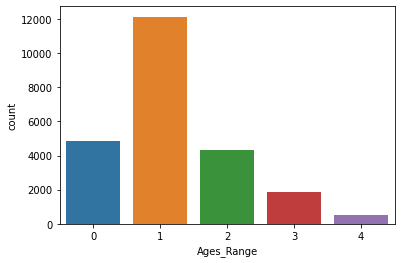

In [ ]:
sns.countplot(df.Ages_Range)

In [ ]:
train_data = df.sample(frac = 0.8,random_state = 25)
left_data = df.drop(train_data.index)

val_data = left_data.sample(frac = 0.6, random_state = 25)
test_data = left_data.drop(val_data.index)

In [ ]:
train_data.shape

(18966, 4)

In [ ]:
val_data.shape

(2845, 4)

In [ ]:
test_data.shape

(1897, 4)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
base_dir = '/content/UTKFace'


train_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=  preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=  preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe = train_data,
                  directory = base_dir,
                  x_col= 'Image_names',
                  y_col = 'Ages_Range',
                  class_mode = 'raw',
                  shuffle = False,
                  target_size=[128,128],
                  batch_size = 32,
                  color_mode='rgb'

)

val_generator = val_datagen.flow_from_dataframe(
                  dataframe = val_data,
                  directory = base_dir,
                  x_col= 'Image_names',
                  y_col = 'Ages_Range',
                  class_mode = 'raw',
                  shuffle = False,
                  target_size=[128,128],
                  batch_size = 32,
                  color_mode='rgb'

)

test_generator = test_datagen.flow_from_dataframe(
                  dataframe = test_data,
                  directory = base_dir,
                  x_col= 'Image_names',
                  y_col = 'Ages_Range',
                  class_mode = 'raw',
                  shuffle = False,
                  target_size=[128,128],
                  batch_size = 32,
                  color_mode='rgb'

)

Found 18966 validated image filenames.
Found 2845 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape = [128,128,3], weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
for layer in vgg.layers:
  layer.trainable = False


layer = keras.layers.Flatten()(vgg.output)
layer = keras.layers.Dense(4096, activation='relu')(layer)
layer = keras.layers.Dense(4096, activation='relu')(layer)
prediction = keras.layers.Dense(5, activation='softmax')(layer)
model = keras.models.Model(inputs=vgg.input, outputs=prediction)
    
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
from pathlib import Path
path = Path('./model_data')
path.mkdir(exist_ok=True)
save_path = './model_data/age_prediction-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.h5'
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpointCallback = ModelCheckpoint(save_path ,monitor=  'val_sparse_categorical_accuracy' , mode = 'max' ,save_best_only = True, verbose = 1)
earlycallback  = EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

callback_list = [checkpointCallback,earlycallback]

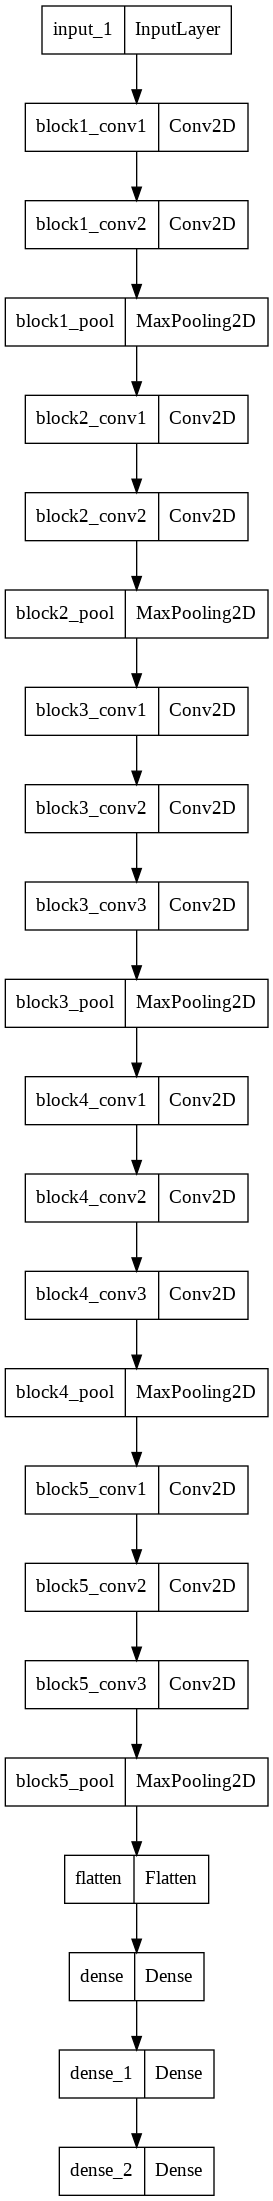

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
result = model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks= callback_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
593/593 [==============================] - ETA: 0s - loss: 0.4992 - sparse_categorical_accuracy: 0.7991
Epoch 1: val_sparse_categorical_accuracy did not improve from 0.73251
593/593 [==============================] - 45s 76ms/step - loss: 0.4992 - sparse_categorical_accuracy: 0.7991 - val_loss: 0.7908 - val_sparse_categorical_accuracy: 0.7065
Epoch 2/10
593/593 [==============================] - ETA: 0s - loss: 0.4709 - sparse_categorical_accuracy: 0.8089
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.73251
593/593 [==============================] - 44s 74ms/step - loss: 0.4709 - sparse_categorical_accuracy: 0.8089 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.7265
Epoch 3/10
593/593 [==============================] - ETA: 0s - loss: 0.4222 - sparse_categorical_accuracy: 0.8286
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.73251
593/593 [==============================] - 44s 74ms/step - loss: 0.4222 - sparse_categorical_accuracy: 

1/1 [==============================] - 0s 331ms/step


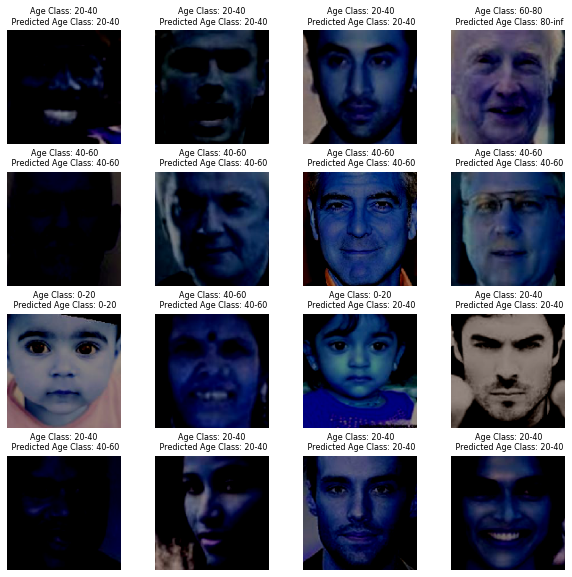

In [ ]:
def show_faces(images, age=None, pred_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Age": [pred_age, age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.axis('off')
        #plt.xticks([])
        #plt.yticks([])
        #plt.grid(False)
        plt.imshow(images[i])
        
        if pred_age[i] is None:
            continue
           
            
        real_age = int(age[i])
        predicted_age = np.argmax(predicted[i])
                
                
        plt.title(f"Age Class: {get_age(real_age)}\n Predicted Age Class: {get_age(predicted_age)}", fontsize=8)
            
        plt.subplots_adjust(wspace=0.3)

sample_validation_images, sample_validation_labels = next(test_generator)
predicted = model.predict(sample_validation_images)
show_faces(sample_validation_images, age=sample_validation_labels, pred_age=predicted)